In [1]:
import sys
import os
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.signal import sosfiltfilt, butter
import logging
import matplotlib.pyplot as plt

sys.path.insert(1, os.path.realpath(os.path.pardir))

In [22]:
class GazeDataProcessor:
    """
    A class for preprocessing gaze data and extracting relevant information.

    Attributes:
        gaze (pd.DataFrame): Gaze data loaded from the CSV file.
        info (pd.DataFrame): Information data loaded from the CSV file.
        events (np.ndarray): Indices of event beginnings.
        gaze_time_col (str): Column name for gaze time.
        gaze_start (datetime): Start time of gaze recording.
        img_start (datetime): Start time of image presentation.
        fs (float): Sampling frequency of the data.
        counter (np.ndarray): Counters for event identification.
        arousal (np.ndarray): Arousal values from the information data.
        valence (np.ndarray): Valence values from the information data.
        raw_data_columns (list): Columns in the gaze data containing raw measurements.
        info_columns (list): Columns expected in the information data.
        preprocessed_data_columns (list): Columns resulting from preprocessing.

    Methods:
        load_data(gaze_path, info_path): Load gaze and information data from CSV files.
        set_timing_params(): Set timing parameters based on loaded data.
        set_counter(): Set counters for event identification.
        set_arousal_valence(): Set arousal and valence values from information data.
        interpolate_gaze_data(method='linear'): Interpolate missing data in gaze data.
        calculate_events_params(): Calculate indices of event beginnings.
        calculate_derived_columns(pmm_win=10, gsr_win=100, hr_win=100): Calculate derived columns.
        apply_bandpass_filter(fmin=0.1, fmax=3, f_order=4): Apply bandpass filter to GSR data.
        extract_epoch_information(t_onset=300): Extract epoch information.
        __call__(...): Perform preprocessing and information extraction.

    Usage:
        processor = GazeDataProcessor()
        time_series, ar_val = processor(gaze_path, info_path, interp_method='linear', ...)
    """
    def __init__(self):
        # Attribute initializations
        self.gaze = None
        self.info = None
        self.events = None
        self.gaze_time_col = None
        self.gaze_start = None
        self.img_start = None
        self.fs = None
        self.counter = None
        self.arousal = None
        self.valence = None
        self.raw_data_columns = ['FPOGX', 'FPOGY', 'LPMM', 'RPMM', 'GSR', 'HR']
        self.info_columns = ['start_time_system', 'time_Images', 'form_response']
        self.preprocessed_data_columns = ['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']

    def load_data(self, gaze_path: str, info_path: str):
        """Load gaze and information data from CSV files."""
        logging.debug("Loading gaze and info data...")
        self.gaze = pd.read_csv(gaze_path)

        missed_cols = list()
        for col in self.raw_data_columns:
            if col not in self.gaze.columns:
                missed_cols.append(col)

        if missed_cols:
            raise ValueError(f"Gaze data must contain {self.raw_data_columns}, but {missed_cols} are omitted")

        self.info = pd.read_csv(info_path)

        missed_cols = list()
        for col in self.info_columns:
            if col not in self.info.columns:
                missed_cols.append(col)
        if missed_cols:
            raise ValueError(f"Info data must contain {self.info_columns}, but {missed_cols} are omitted")

    def set_timing_params(self):
        """Set timing parameters based on loaded data."""
        time_cols = [col for col in self.gaze.columns if col.startswith('TIME(')]

        if not time_cols:
            raise ValueError("Gaze data must contain at least one column starting with 'TIME('")

        self.gaze_time_col = time_cols[0]
        self.gaze_start = datetime.strptime(self.gaze_time_col[5:-1], '%Y/%m/%d %H:%M:%S.%f')
        self.img_start = datetime.strptime(self.info.start_time_system[0], '%d/%m/%y %H:%M:%S.%f')
        self.fs = self.gaze.CNT.iloc[-1] / self.gaze[self.gaze_time_col].iloc[-1]
        time_difference = abs((self.img_start.timestamp() - self.gaze_start.timestamp()) * 1000)
        if time_difference > 1_000_000:
            raise ValueError('Time difference between start of recording and image presentation is too large')

    def set_counter(self):
        """Set counters for event identification."""
        self.counter = (
            np.array(
                self.info.time_Images[1::2] - ( ( self.img_start.timestamp() - self.gaze_start.timestamp() ) * 1000 )
            ) / 1000 * self.fs
        ).astype(int)

    def set_arousal_valence(self):
        """Set arousal and valence values from information data."""
        self.arousal = np.array(self.info.form_response[1::2]).astype(int)
        self.valence = np.array(self.info.form_response[2::2]).astype(int)

    def interpolate_gaze_data(self, method: str = 'linear'):
        """Interpolate missing data in gaze data."""
        logging.debug(f"Interpolating missing data in gaze using {method} interpolation...")
        self.gaze[self.raw_data_columns] = self.gaze[self.raw_data_columns].interpolate(method=method, axis=0)

    def calculate_events_params(self):
        """Calculate indices of event beginnings."""
        logging.debug("Calculating events information...")
        ep_begin = np.zeros(len(self.gaze))
        ep_begin[self.counter] = 1
        self.gaze['ep_begin'] = ep_begin
        self.events = np.where(self.gaze.ep_begin == 1)[0]

    def calculate_derived_columns(self, pmm_win: int = 10, gsr_win: int = 100, hr_win: int = 100):
        """Calculate derived columns."""
        logging.debug("Calculating derived columns...")
        self.gaze['mean_PMM'] = (self.gaze.LPMM + self.gaze.RPMM) / 2
        logging.debug(f"Computing rolling mean for PMM with window size = {pmm_win}...")
        self.gaze.mean_PMM = self.gaze.mean_PMM.rolling(window=pmm_win, min_periods=0, center=True).mean()
        logging.debug(f"Computing rolling mean for GSR with window size = {gsr_win}...")
        self.gaze.GSR = self.gaze.GSR.rolling(window=gsr_win, min_periods=0, center=True).mean()
        logging.debug(f"Computing rolling mean for HR with window size = {hr_win}...")
        self.gaze.HR = self.gaze.HR.rolling(window=hr_win, min_periods=0, center=True).mean()

    def apply_bandpass_filter(self, fmin: float = 0.1, fmax: float = 3, f_order: int = 4):
        """Apply bandpass filter to GSR data."""
        logging.debug(f"Applying bandpass {f_order}-order IIR filter to GSR from {fmin} to {fmax} Hz...")
        low = fmin / (self.fs / 2)
        high = fmax / (self.fs / 2)
        sos = butter(f_order, [low, high], btype='bandpass', output='sos')
        self.gaze.GSR = sosfiltfilt(sos, self.gaze.GSR)

    def extract_epoch_information(self, t_onset: int = 300):
        """Data epoching."""
        logging.debug("Extracting epoch information...")
        ns = len(self.events)

        time_series = np.zeros((ns, t_onset, len(self.preprocessed_data_columns)))
        ar_val = np.zeros((ns, 2))
        ar_val[:, 0] = self.arousal
        ar_val[:, 1] = self.valence

        for n, i in enumerate(self.events[1:-1]):
            time_series[n] = np.array(self.gaze[self.preprocessed_data_columns][i:(i + t_onset)])

        logging.info(f'NaN count in time_series: {np.isnan(time_series).sum()}')

        return time_series, ar_val

    def __call__(
        self,
        gaze_path: str,
        info_path: str,
        interp_method: str = 'linear',
        ppm_win: int = 10,
        gsr_win: int = 100,
        hr_win: int = 100,
        fmin: float = 0.1,
        fmax: float = 3,
        f_order: int = 4,
        t_onset: int = 300
    ):
        """
        Perform preprocessing and information extraction.

        Args:
            gaze_path (str): Path to the gaze data CSV file.
            info_path (str): Path to the information data CSV file.
            interp_method (str): Interpolation method for gaze data.
            ppm_win (int): Window size for mean_PMM calculation.
            gsr_win (int): Window size for GSR rolling mean calculation.
            hr_win (int): Window size for HR rolling mean calculation.
            fmin (float): Minimum frequency for the bandpass filter.
            fmax (float): Maximum frequency for the bandpass filter.
            f_order (int): Order of the bandpass filter.
            t_onset (int): Length of time series to extract.

        Returns:
            tuple: A tuple containing time_series and ar_val.
        """
        self.load_data(gaze_path, info_path)
        self.set_timing_params()
        self.set_counter()
        self.set_arousal_valence()

        self.interpolate_gaze_data(interp_method)
        self.calculate_events_params()
        self.calculate_derived_columns(ppm_win, gsr_win, hr_win)
        self.apply_bandpass_filter(fmin, fmax, f_order)
        return self.extract_epoch_information(t_onset)


def find_repeating_ranges(arr: list[float], tol: int = 2) -> list[tuple[int, int]]:
    """
    Find ranges of repeating elements in a 1D list.

    Args:
        arr (List[float]): The input 1D list of elements.
        tol (int, optional): Minimum length of repeating sequence to consider. Defaults to 2.

    Returns:
        List[Tuple[int, int]]: A list of tuples representing the starting and ending indices of repeating ranges.
    """
    repeating_ranges = []
    start_index = None

    for i in range(len(arr) - 1):
        if arr[i] == arr[i + 1]:
            if start_index is None:
                start_index = i
        elif start_index is not None:
            if i - start_index + 1 >= tol:
                repeating_ranges.append((start_index, i))
            start_index = None

    if start_index is not None and len(arr) - start_index >= tol:
        repeating_ranges.append((start_index, len(arr) - 1))

    return repeating_ranges


def concatenate_overlapping_ranges(ranges: list[tuple[int, int]]) -> list[tuple[int, int]]:
    """
    Concatenate overlapping ranges in a list of tuples.

    Args:
        ranges (List[Tuple[int, int]]): A list of tuples representing ranges where each tuple contains start and end indices.

    Returns:
        List[Tuple[int, int]]: A list of tuples representing the concatenated non-overlapping ranges.
    """
    ranges.sort()  # Sort ranges based on the start index
    concatenated_ranges = []

    if not ranges:
        return concatenated_ranges

    current_range = ranges[0]

    for i in range(1, len(ranges)):
        if ranges[i][0] <= current_range[1] + 1:
            current_range = (current_range[0], max(current_range[1], ranges[i][1]))
        else:
            concatenated_ranges.append(current_range)
            current_range = ranges[i]

    concatenated_ranges.append(current_range)

    return concatenated_ranges


def find_critical_ranges(arr: list[float], threshold: tuple[float, float], extension: int = 2) -> list[tuple[int, int]]:
    """
    Find ranges where values are outside a specified threshold.

    Args:
        arr (List[float]): The input 1D list of values.
        threshold (Tuple[float, float]): A tuple containing the lower and upper threshold values.
        extension (int, optional): Extension factor for ranges with small gaps. Defaults to 2. This guarantees that the range will be at least 2*extension samples long.

    Returns:
        List[Tuple[int, int]]: A list of tuples representing the starting and ending indices of critical ranges.
    """
    outside_ranges = []
    start_index = None
    extension_samples = extension

    for i, value in enumerate(arr):
        if not (threshold[0] <= value <= threshold[1]):
            if start_index is None:
                start_index = i
        elif start_index is not None:
            end_index = i
            pair_len = end_index - start_index

            if pair_len < 2*extension_samples:
                start_index = max(start_index - extension_samples, 0)
                end_index = min(end_index + extension_samples - pair_len, len(arr) - 1)

            outside_ranges.append((start_index, end_index))
            start_index = None

    if start_index is not None:
        outside_ranges.append((start_index, len(arr) - 1))

    return concatenate_overlapping_ranges(outside_ranges)


def plot_critical_ranges(
    preprocessor: GazeDataProcessor,
    threshold_dict: dict[str, tuple[float, float]],
    repeat_tol: int = 500,
    figsize: tuple[float, float] = None,
    title: str = None
) -> plt.Figure:
    """
    Plot critical ranges in preprocessed data columns.

    Args:
        preprocessor (GazeDataProcessor): An instance of the GazeDataProcessor class.
        threshold_dict (Dict[str, Tuple[float, float]]): A dictionary specifying threshold ranges for each column of GazeDataProcessor.preprocessed_data_columns.
        repeat_tol (int, optional): Minimum length of repeating sequence to consider. Defaults to 500.
        figsize (Optional[Tuple[float, float]], optional): Figure size. Defaults to None.
        title (Optional[str], optional): Figure title. Defaults to None.

    Returns:
        plt.Figure: A Matplotlib figure containing the plotted critical ranges.
    """
    if figsize is None:
        figsize = (20, 10)
    if title is None:
        title = ''
    fig, axs = plt.subplots(len(preprocessor.preprocessed_data_columns), 1, figsize=figsize)

    for ax, colname in zip(axs, preprocessor.preprocessed_data_columns):
        coldata = preprocessor.gaze[colname].to_numpy()
        critical_ranges = concatenate_overlapping_ranges(find_repeating_ranges(coldata, tol=repeat_tol) + find_critical_ranges(coldata, threshold_dict[colname]))
        t = np.arange(len(coldata)) / preprocessor.fs

        for critical in critical_ranges:
            ax.fill_between([t[critical[0]], t[critical[1]]], threshold_dict[colname][0], threshold_dict[colname][1], color='tab:red', alpha=0.25, linewidth=0.5, zorder=2)

        ax.plot(t, coldata, zorder=0, linewidth=0.75, color='tab:blue')
        ax.set_ylabel(colname, labelpad=10)
        ax.set_ylim(*threshold_dict[colname])
        ax.set_xlim(t[0] - 0.01 * len(t) / preprocessor.fs, t[-1] + 0.01 * len(t) / preprocessor.fs)
        ax.vlines(t[preprocessor.events], ymin=threshold_dict[colname][0], ymax=threshold_dict[colname][1], color='tab:grey', alpha=0.5, linewidth=0.5, zorder=-1)
        ax.ticklabel_format(style='plain', axis='y', scilimits=(0,0), useMathText=True)

        if ax != axs[-1]:
            ax.tick_params(bottom=False)
            plt.setp(ax.get_xticklabels(), visible=False)

    if title:
        fig.suptitle(title, y=.925)

    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.15)
    return fig


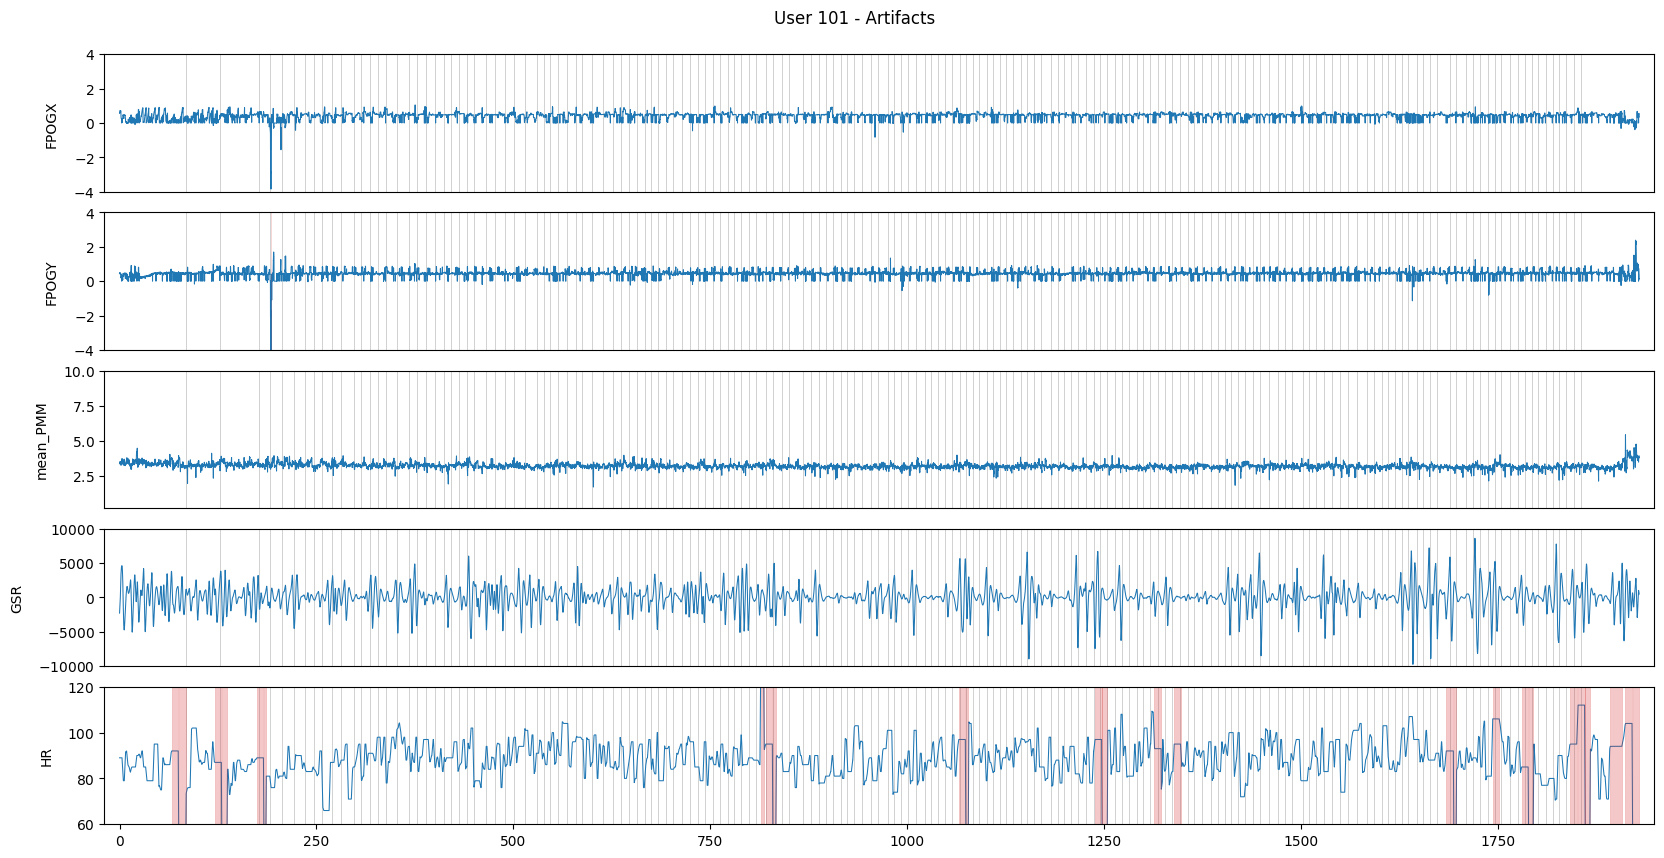

In [23]:
threshold_dict = {
    'FPOGX': (-4., 4.),
    'FPOGY': (-4., 4.),
    'mean_PMM': (0.2, 10.),
    'GSR': (-10_000., 10_000.),
    'HR': (60., 120.)
}

subject = 101
preprocessor = GazeDataProcessor()
ts, labels = preprocessor(
    f'/home/user/Downloads/User {subject}_all_gaze.csv',
    f'/home/user/Downloads/subject-{subject}.csv'
)

fig_size = (20, 10)
fig = plot_critical_ranges(preprocessor, threshold_dict, figsize=fig_size, title=f'User {subject} - Artifacts')
plt.show()